In [219]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import re



In [220]:
my_classs = ('class1','class2','class3','class4','class5','class6','class7','class8','class9')

In [222]:
data = pd.read_csv("train.csv")
data = data.sample(frac = 1) 
sc_X = StandardScaler()
Y = data["target"]
del data['target']
del data['id']
X =  pd.DataFrame(sc_X.fit_transform(data))
X = X.to_numpy()
Y = Y.to_numpy()
Y = np.array([Y])
Y = Y.reshape((61878,1))


In [223]:
class  Training_DataSet(Dataset):
    def __init__(self,X,Y,transform):
        self.X = X
        self.Y = Y
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self,idx):
        features = self.X[idx]  
        target = self.Y[idx]

        
        sample = {"features":features,"target":target}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [224]:
def isdigit(target):
    digit = re.findall("\d+", str(target))
    digit = digit[0]
    return digit

In [225]:


class to_tensor_training(object):
    def __call__(self,sample):
        features , target = sample['features'],sample['target']
        features = np.array([features])
        features = features.astype('float32')
        features = torch.from_numpy(features)
        features = features.float()
        target = isdigit(target)
        target = int(target)-1

        target = np.array([target])
        target = torch.from_numpy(target)
        target = target.long()
        
        return {"features":features,"target":target}
        

In [226]:
transformed_dataset = Training_DataSet(X = X_train,
                                       Y = Y_train,
                                       transform = to_tensor_training())

In [227]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['features'].shape,sample['target'])

    if i == 3:
        break

0 torch.Size([1, 93]) tensor([2])
1 torch.Size([1, 93]) tensor([5])
2 torch.Size([1, 93]) tensor([1])
3 torch.Size([1, 93]) tensor([7])


In [228]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(93,128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256,512)
        self.fc4 = nn.Linear(512,64)
        self.fc5 = nn.Linear(64,9)
        
    def forward(self,x):
        #drouput_activation1 = nn.Dropout(p=0.3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
        

In [229]:
net = Net()
trainloader = torch.utils.data.DataLoader(transformed_dataset,batch_size=4, shuffle=True,num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [232]:
loss_array = []
correct = 0
total = 0

accuracy_array = []
for epoch in range(11):
    running_loss = 0
    for i , data in enumerate(trainloader,0):
        features , target = data['features'],data['target']
        target = target.squeeze()
        optimizer.zero_grad()
        outputs = net(features)
        outputs = outputs.squeeze()
        _, predictions = torch.max(outputs,1)
        total += target.size(0)
        correct += (predictions == target).sum().item()
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
    loss_array.append(running_loss / len(trainloader))
    
    print("Epoch: {}/ 10.. ".format(epoch+1),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)))
    print("Accuracy  %d %%" %(100*correct/total))
    correct = 0
    total = 0
print("Finished training")

Epoch: 1/ 10..  Training Loss: 0.878.. 
Accuracy  68 %
Epoch: 2/ 10..  Training Loss: 0.601.. 
Accuracy  76 %
Epoch: 3/ 10..  Training Loss: 0.563.. 
Accuracy  78 %
Epoch: 4/ 10..  Training Loss: 0.538.. 
Accuracy  78 %
Epoch: 5/ 10..  Training Loss: 0.520.. 
Accuracy  79 %
Epoch: 6/ 10..  Training Loss: 0.502.. 
Accuracy  80 %
Epoch: 7/ 10..  Training Loss: 0.486.. 
Accuracy  80 %
Epoch: 8/ 10..  Training Loss: 0.474.. 
Accuracy  80 %
Epoch: 9/ 10..  Training Loss: 0.463.. 
Accuracy  81 %
Epoch: 10/ 10..  Training Loss: 0.449.. 
Accuracy  81 %
Epoch: 11/ 10..  Training Loss: 0.437.. 
Accuracy  82 %
Finished training


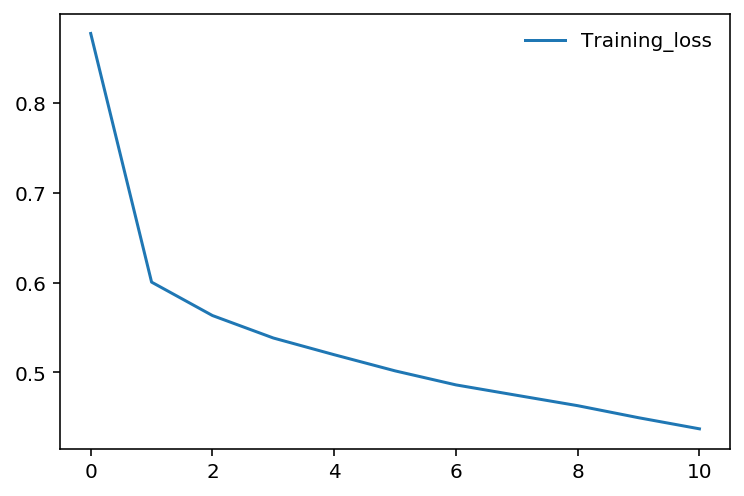

In [233]:
# Let us plot our loss over time
%matplotlib inline
%config InlineBackend.figure_format = "retina"


import matplotlib.pyplot as plt

plt.plot(loss_array,label="Training_loss")
plt.legend(frameon=False)

In [255]:
def view_classify( ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6 ))
    ax1.axis('off')
    ax2.barh(np.arange(9), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['class1','class2','class3','class4','class5','class6','class7','class8','class9'])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


### Predicting some values 

True value =  tensor([6])


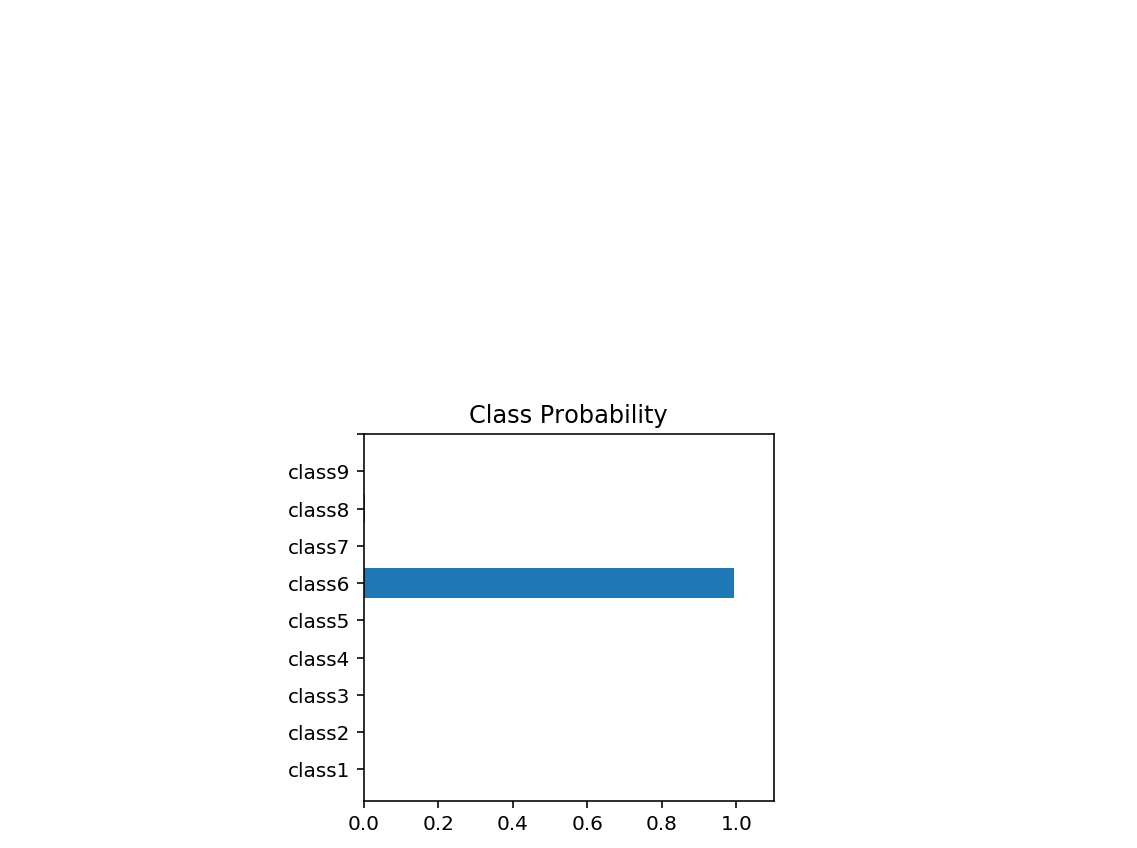

In [256]:
sample = next(iter(transformed_dataset))
sample = transformed_dataset[1]
feature ,target = sample['features'],sample['target']
output = net(feature)
feature = F.log_softmax(output, dim=1)
ps = torch.exp(feature)
print("True value = ",target+1)
view_classify(ps)